<a href="https://colab.research.google.com/github/teamgaon/SANUP/blob/main/220315_sm_SANUP_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리, 패키지

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the followin line:
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install transformers

     |████████████████████████████████| 312 kB 5.1 MB/s 
     |████████████████████████████████| 3.8 MB 79.0 MB/s 
     |████████████████████████████████| 1.1 MB 70.6 MB/s 
     |████████████████████████████████| 212 kB 50.9 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 134 kB 82.0 MB/s 
     |████████████████████████████████| 127 kB 83.5 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 85.3 MB/s 
     |████████████████████████████████| 144 kB 79.3 MB/s 
     |████████████████████████████████| 596 kB 77.7 MB/s 
     |████████████████████████████████| 6.5 MB 76.4 MB/s 
     |████████████████████████████████| 895 kB 77.5 MB/s 
     |████████████████████████████████| 1.2 MB 78.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
   

- TPU 사용을 위한 accelerate

In [ ]:
from accelerate import Accelerator

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from transformers import TrainingArguments, Trainer
from transformers import AutoModel,AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
import gc
from transformers import AdamW
from transformers import get_scheduler, get_cosine_with_hard_restarts_schedule_with_warmup
from tqdm.auto import tqdm
from datasets import load_metric
import warnings
warnings.filterwarnings('ignore')
from accelerate import notebook_launcher

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SANUP/1. 실습용자료.txt', sep='|', encoding='cp949')
test = pd.read_csv('/content/drive/MyDrive/SANUP/2. 모델개발용자료.txt', sep='|', encoding='cp949')

In [ ]:
df = df.fillna(0)

In [ ]:
df['text'] = df['text_obj'].astype(str) + " " + df['text_mthd'].astype(str) + " " + df['text_deal'].astype(str)
df['target'] = df['digit_1'] + " " + df['digit_2'].astype(str) + " " + df['digit_3'].astype(str)
df

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,text,target
0,id_0000001,S,95,952,카센터에서,자동차부분정비,타이어오일교환,카센터에서 자동차부분정비 타이어오일교환,S 95 952
1,id_0000002,G,47,472,상점내에서,일반인을 대상으로,채소.과일판매,상점내에서 일반인을 대상으로 채소.과일판매,G 47 472
2,id_0000003,G,46,467,절단하여사업체에도매,공업용고무를가지고,합성고무도매,절단하여사업체에도매 공업용고무를가지고 합성고무도매,G 46 467
3,id_0000004,G,47,475,영업점에서,일반소비자에게,열쇠잠금장치,영업점에서 일반소비자에게 열쇠잠금장치,G 47 475
4,id_0000005,Q,87,872,어린이집,보호자의 위탁을 받아,취학전아동보육,어린이집 보호자의 위탁을 받아 취학전아동보육,Q 87 872
...,...,...,...,...,...,...,...,...,...
999995,id_0999996,C,13,134,제품입고,워싱,청바지워싱,제품입고 워싱 청바지워싱,C 13 134
999996,id_0999997,F,42,424,현장에서,고객의요청에의해,실내인테리어,현장에서 고객의요청에의해 실내인테리어,F 42 424
999997,id_0999998,G,47,474,영업점에서,일반소비자에게,여성의류 판매,영업점에서 일반소비자에게 여성의류 판매,G 47 474
999998,id_0999999,P,85,856,사업장에서,일반고객을대상으로,필라테스,사업장에서 일반고객을대상으로 필라테스,P 85 856


In [ ]:
train = df[['text', 'target']]
train

,text,target
0,카센터에서 자동차부분정비 타이어오일교환,S 95 952
1,상점내에서 일반인을 대상으로 채소.과일판매,G 47 472
2,절단하여사업체에도매 공업용고무를가지고 합성고무도매,G 46 467
3,영업점에서 일반소비자에게 열쇠잠금장치,G 47 475
4,어린이집 보호자의 위탁을 받아 취학전아동보육,Q 87 872
...,...,...
999995,제품입고 워싱 청바지워싱,C 13 134
999996,현장에서 고객의요청에의해 실내인테리어,F 42 424
999997,영업점에서 일반소비자에게 여성의류 판매,G 47 474
999998,사업장에서 일반고객을대상으로 필라테스,P 85 856


# 토크나이저, 함수

In [ ]:
from transformers import AutoTokenizer

checkpoint = 'monologg/kobert'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['labels'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)

In [ ]:
my_dict = {}
for i in range(len(train['target'].unique())):
  my_dict[train['target'].unique()[i]] = i

def target_to_num(target:str):
  return my_dict[target]

train['target'] = train['target'].map(target_to_num)
train

,text,target
0,카센터에서 자동차부분정비 타이어오일교환,0
1,상점내에서 일반인을 대상으로 채소.과일판매,1
2,절단하여사업체에도매 공업용고무를가지고 합성고무도매,2
3,영업점에서 일반소비자에게 열쇠잠금장치,3
4,어린이집 보호자의 위탁을 받아 취학전아동보육,4
...,...,...
999995,제품입고 워싱 청바지워싱,103
999996,현장에서 고객의요청에의해 실내인테리어,68
999997,영업점에서 일반소비자에게 여성의류 판매,11
999998,사업장에서 일반고객을대상으로 필라테스,12


In [ ]:
train[train['text'].isnull()]

,text,target


In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# 학습

* Model
  + Roberta-large

* Optimizer
  + AdamW

* Learning rate scheduler
  + Cosine annealing with warmup

In [ ]:
def training_function():
  accelerator = Accelerator()

  train_dataloader = torch.utils.data.DataLoader(
                    train_dataset, 
                    batch_size=16, sampler=train_subsampler)
  eval_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=16, sampler=test_subsampler)

  config = AutoConfig.from_pretrained(checkpoint)
  config.num_labels = len(train['target'].unique())
  model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

  optimizer = AdamW(model.parameters(), lr=	1e-5)

  model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(model, optimizer, train_dataloader, eval_dataloader)

  num_epochs = 10
  num_training_steps = num_epochs * len(train_dataloader)
  progress_bar = tqdm(range(num_training_steps))
  lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
      optimizer=optimizer,
      num_warmup_steps=1,
      num_training_steps=num_training_steps,
  )

  for epoch in range(num_epochs):
      train_acc = 0.0
      test_acc = 0.0

      model.train()
      for batch_id, batch in enumerate(train_dataloader):
          outputs = model(batch['input_ids'], batch['attention_mask'], batch['token_type_ids'])
          loss = F.cross_entropy(outputs[0], batch['labels'])
          accelerator.backward(loss)

          optimizer.step()
          lr_scheduler.step()
          optimizer.zero_grad()
          progress_bar.update(1)
          train_acc += calc_accuracy(outputs.logits, batch['labels'])
      print("epoch {} train acc {}".format(epoch+1, train_acc / (batch_id+1)))

      model.eval()
      for batch_id, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch['input_ids'], batch['attention_mask'], batch['token_type_ids'])

        test_acc += calc_accuracy(outputs.logits, batch['labels'])
      print("epoch {} test acc {}".format(epoch+1, test_acc / (batch_id+1)))
      gc.collect()
  accelerator.wait_for_everyone()
  unwrapped_model = accelerator.unwrap_model(model)
  unwrapped_model.save_pretrained('/content/drive/MyDrive/SANUP' + str(fold), save_function=accelerator.save)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

print('--------------------------------')

tokenized_train = tokenizer(
  list(train['text']),
  return_tensors="pt",
  max_length=128, # Max_Length = 190
  padding=True,
  truncation=True,
  add_special_tokens=True
  )
  
for fold, (train_ids, test_ids) in enumerate(kfold.split(train, train['target'])):
  print(f'FOLD {fold}')

  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  train_label = train['target']

  train_dataset = BERTDataset(tokenized_train, train_label)

  notebook_launcher(training_function)

--------------------------------
FOLD 0
Launching a training on 8 TPU cores.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly i

  0%|          | 0/62500 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/62500 [00:00<?, ?it/s]

  0%|          | 0/62500 [00:00<?, ?it/s]

  0%|          | 0/62500 [00:00<?, ?it/s]

  0%|          | 0/62500 [00:00<?, ?it/s]

  0%|          | 0/62500 [00:00<?, ?it/s]

  0%|          | 0/62500 [00:00<?, ?it/s]

  0%|          | 0/62500 [00:00<?, ?it/s]

epoch 1 train acc 0.20026
epoch 1 train acc 0.20064
epoch 1 train acc 0.20156
epoch 1 train acc 0.19954
epoch 1 train acc 0.19989
epoch 1 train acc 0.19946
epoch 1 train acc 0.19888
epoch 1 train acc 0.20235
epoch 1 test acc 0.22636756238003838
epoch 1 test acc 0.22620761356365962
epoch 1 test acc 0.229766474728087
epoch 1 test acc 0.22960652591170824
epoch 1 test acc 0.22816698656429943
epoch 1 test acc 0.2224488163787588
epoch 1 test acc 0.2282869481765835
epoch 1 test acc 0.22912667946257198
epoch 2 train acc 0.23084
epoch 2 train acc 0.2292
epoch 2 train acc 0.23118
epoch 2 train acc 0.22904
epoch 2 train acc 0.23107
epoch 2 train acc 0.23154
epoch 2 train acc 0.2313
epoch 2 train acc 0.23031
epoch 2 test acc 0.2340850927703135
epoch 2 test acc 0.236084452975048
epoch 2 test acc 0.23888355726167626
epoch 2 test acc 0.23432501599488165
epoch 2 test acc 0.23768394113883556
epoch 2 test acc 0.23128598848368523
epoch 2 test acc 0.23960332693538067
epoch 2 test acc 0.24036308381317978


In [ ]:
tokenized_train

{'input_ids': tensor([[2, 0, 3]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

# 추론

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

test_label = label_to_num(test['label'].values)

tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = BERTDataset(tokenized_test, test_label)

dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

for fold in range(5):

  config = AutoConfig.from_pretrained(checkpoint)
  config.num_labels = 3
  model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/220228/model' + str(fold), num_labels=3)
  model.resize_token_embeddings(tokenizer.vocab_size)
  accelerator = Accelerator()
  model = accelerator.unwrap_model(model)

  output_pred = []
  output_prob = []

  model, dataloader= accelerator.prepare(model, dataloader)

  model.eval()

  for i, data in enumerate(tqdm(dataloader)):
      with torch.no_grad():
          outputs = model(
              input_ids=data['input_ids'],
              attention_mask=data['attention_mask']
          )
      logits = outputs[0]
      prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
      logits = logits.detach().cpu().numpy()
      result = np.argmax(logits, axis=-1)
      output_pred.append(result)
      output_prob.append(prob)
      
  pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()

  def num_to_label(label):
      label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
      str_label = []

      for i, v in enumerate(label):
          str_label.append([i,label_dict[v]])
      
      return str_label

  answer = num_to_label(pred_answer)

  df_label = pd.DataFrame(answer, columns=['index', 'label'])
  df_prob = pd.DataFrame(output_prob)

  df_label.to_csv('/content/drive/MyDrive/220228/pred_label'+str(fold)+'.csv', index=False)
  df_prob.to_csv('/content/drive/MyDrive/220228/pred_prob'+str(fold)+'.csv', index=False)

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

## hardvoting

### voting algorithm 
  + <strong> 5개의 모델이 판단한 5개의 label 중 동일한 label이 3개 이상이면 해당 label로 분류, 그 외의 경우는 neutral로 분류
  
  + 앞선 과정을 거쳐 neutral로 분류된 데이터 중 5개의 label이 neutral과 entailment, <br> neutral과 contradiction이 경합하면 entailment와 contradiction으로 재분류 </strong>

In [ ]:
test = pd.read_csv(os.path.join(PATH, 'test_data.csv'), encoding='utf-8')

In [ ]:
pred0 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_label0.csv')
pred1 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_label1.csv')
pred2 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_label2.csv')
pred3 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_label3.csv')
pred4 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_label4.csv')

In [ ]:
test['label0'] = pred0['label']
test['label1'] = pred1['label']
test['label2'] = pred2['label']
test['label3'] = pred3['label']
test['label4'] = pred4['label']
df = test

In [ ]:
df.head(3)

,index,premise,hypothesis,label,label0,label1,label2,label3,label4
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer,contradiction,contradiction,contradiction,contradiction,contradiction
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer,neutral,neutral,neutral,neutral,neutral
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer,entailment,entailment,entailment,entailment,entailment


* 모델의 예측 결과가 neutral에 치중되는 경향을 보임
  - label 별로 threshold를 다르게 해야 할 필요가 있음

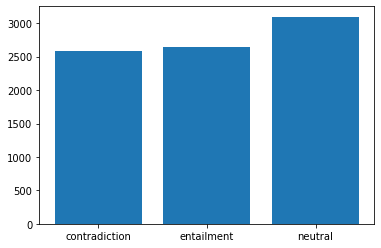

In [ ]:
num_contradiction = len(df[df['label0'] == 'contradiction']) + len(df[df['label1'] == 'contradiction']) + len(df[df['label2'] == 'contradiction']) + len(df[df['label3'] == 'contradiction']) + len(df[df['label4'] == 'contradiction'])
num_entailment = len(df[df['label0'] == 'entailment']) + len(df[df['label1'] == 'entailment']) + len(df[df['label2'] == 'entailment']) + len(df[df['label3'] == 'entailment']) + len(df[df['label4'] == 'entailment'])
num_neutral = len(df[df['label0'] == 'neutral']) + len(df[df['label1'] == 'neutral']) + len(df[df['label2'] == 'neutral']) + len(df[df['label3'] == 'neutral']) + len(df[df['label4'] == 'neutral'])

labels = ['contradiction', 'entailment', 'neutral']
counts = [num_contradiction, num_entailment, num_neutral]

plt.bar(labels, counts)
plt.show()

In [ ]:
def label_count(df):
  num_neutral = 0
  num_contradiction = 0
  num_entailment = 0
  cols = ['label0', 'label1', 'label2', 'label3', 'label4']

  for col in cols:
    if df[col] == 'neutral':
      num_neutral = num_neutral + 1
    if df[col] == 'contradiction':
      num_contradiction = num_contradiction + 1
    if df[col] == 'entailment':
      num_entailment = num_entailment + 1

  return [num_neutral, num_contradiction, num_entailment]

temp = df.apply(label_count, axis=1)

df['temp'] = temp

df['neutral'] = 0
df['contradiction'] = 0
df['entailment'] = 0

def list_to_num(list:list):
  return list[0]
df['neutral'] = df['temp'].map(list_to_num)

def list_to_num(list:list):
  return list[1]
df['contradiction'] = df['temp'].map(list_to_num)

def list_to_num(list:list):
  return list[2]
df['entailment'] = df['temp'].map(list_to_num)

def voting(df):
  cols = ['neutral', 'contradiction', 'entailment']
  for col in cols:
    if df[col] > 2:
      return col
  return 'neutral'

df['label'] = df.apply(voting, axis=1)

- 동일한 label이 3개 이상이면 해당 label로 분류
- 그 외 neutral

In [ ]:
df.head(3)

,index,premise,hypothesis,label,label0,label1,label2,label3,label4,temp,neutral,contradiction,entailment
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,contradiction,contradiction,contradiction,contradiction,contradiction,contradiction,"[0, 5, 0]",0,5,0
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,neutral,neutral,neutral,neutral,neutral,neutral,"[5, 0, 0]",5,0,0
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,entailment,entailment,entailment,entailment,entailment,entailment,"[0, 0, 5]",0,0,5


- label이 neutral에 지나치게 치중되는 경향을 보임

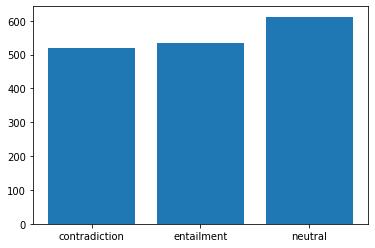

In [ ]:
num_contradiction = df['label'].value_counts()['contradiction']
num_entailment = df['label'].value_counts()['entailment']
num_neutral = df['label'].value_counts()['neutral']

counts = [num_contradiction, num_entailment, num_neutral]

plt.bar(labels, counts)
plt.show()

- label이 neutral인 데이터 중 entailment와 contradiction로 분류될 가능성이 있는 데이터의 label 조정
  + neutral: 3 / contradiction: 2 -> **contradiction**
  + neutral: 3 / entailment: 2 -> **entailment**
  + neutral: 4 /  contradiction: 1 -> **contradiction**
  + neutral: 4 / entailment: 1 -> **entailment**

In [ ]:
def make_label(list:list):
  if list == [3, 2, 0] :
    return 'contradiction'
  if list == [3, 0, 2]:
    return 'entailment'
  if list == [4, 1, 0]:
    return 'contradiction'
  if list == [4, 0, 1]:
    return 'entailment'
  else :
    return 'answer'

my_label = df['temp'].map(make_label)
df['my_label'] = my_label
my_answer = df[df['my_label'] != 'answer']
df.loc[my_answer.index, 'label'] = my_answer['my_label']

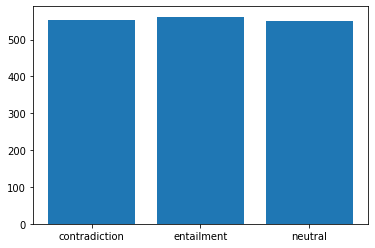

In [ ]:
num_contradiction = df['label'].value_counts()['contradiction']
num_entailment = df['label'].value_counts()['entailment']
num_neutral = df['label'].value_counts()['neutral']

counts = [num_contradiction, num_entailment, num_neutral]

plt.bar(labels, counts)
plt.show()

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/KLUE/sample_submission.csv')

In [ ]:
submission['label'] = df['label']

In [ ]:
submission

,index,label
0,0,contradiction
1,1,neutral
2,2,entailment
3,3,contradiction
4,4,contradiction
...,...,...
1661,1661,neutral
1662,1662,entailment
1663,1663,neutral
1664,1664,neutral


In [ ]:
submission.to_csv('/content/drive/MyDrive/sm_220228/submission_hard.csv', index=False)

## softvoting

###  voting algorithm
  + <strong> 동일한 premise에 세 가지의 hypothesis가 매칭되는 경우, 가장 높은 확률을 갖는 hypothesis부터 label 부여  
  + 동일한 premise에 세 가지의 hypothesis가 매칭되지 않는 경우, 가장 큰 확률을 갖는 label 부여 </strong>

In [ ]:
pred0 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_prob0.csv')
pred1 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_prob1.csv')
pred2 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_prob2.csv')
pred3 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_prob3.csv')
pred4 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_prob4.csv')

In [ ]:
pred = pd.DataFrame((np.array(pred0) + np.array(pred1) + np.array(pred2) + np.array(pred3) + np.array(pred4))/5)
test = pd.read_csv(os.path.join(PATH, 'test_data.csv'), encoding='utf-8')
test = pd.concat([test, pred], axis=1)
test.head(3)

,index,premise,hypothesis,label,0,1,2
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer,0.000112,0.999817,0.000071
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer,0.003301,0.000062,0.996636
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer,0.999655,0.000170,0.000176


* 모델의 예측 결과가 neutral에 치중되는 경향을 보임
  - label 별로 threshold를 다르게 해야 할 필요가 있음

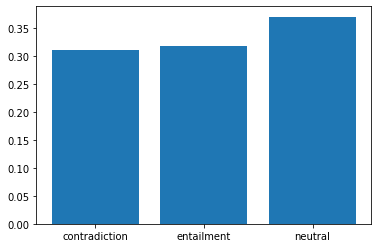

In [ ]:
prob_entailment = test[0].mean()
prob_contradiction = test[1].mean()
prob_neutral = test[2].mean()

probs = [prob_contradiction, prob_entailment, prob_neutral]

plt.bar(labels, probs)
plt.show()

In [ ]:
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])
    
    return str_label

answer = num_to_label(np.argmax(np.array(pred), axis=-1))

test['label'] = pd.DataFrame(answer)[1]
test.head(3)

,index,premise,hypothesis,label,0,1,2
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,contradiction,0.000112,0.999817,0.000071
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,neutral,0.003301,0.000062,0.996636
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,entailment,0.999655,0.000170,0.000176


- 가장 큰 확률을 갖는 label을 부여하면 hardvoting과 같이 neutral에 치중되는 경향을 보임

- 분류된 데이터 중 5개의 label이 neutral과 entailment, neutral과 contradiction이 경합하면 entailment와 contradiction으로 재분류

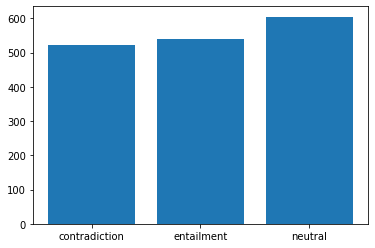

In [ ]:
num_contradiction = test['label'].value_counts()['contradiction']
num_entailment = test['label'].value_counts()['entailment']
num_neutral = test['label'].value_counts()['neutral']

counts = [num_contradiction, num_entailment, num_neutral]

plt.bar(labels, counts)
plt.show()

- 보편적으로 하나의 premise에 세 가지의 hypothesis가 매칭

In [ ]:
test.sort_values(by='premise')[:15]

,index,premise,hypothesis,label,0,1,2
1070,1070,10명이 함께 사용하기 불편함없이 만족했다.,10명이 함께 사용하기에 불편하지 않았다.,entailment,0.999548,0.000320,0.000133
1034,1034,10명이 함께 사용하기 불편함없이 만족했다.,남녀노소 10명이 함께 여행을 갔다.,neutral,0.000141,0.000073,0.999786
1644,1644,10명이 함께 사용하기 불편함없이 만족했다.,함께 사용하기에 10명은 너무 많은 숫자이다.,contradiction,0.000045,0.799890,0.200065
637,637,10층에 건물사람들만 이용하는 수영장과 썬베드들이 있구요.,건물사람들을 위한 수영장과 썬베드가 있습니다.,entailment,0.999418,0.000352,0.000231
1122,1122,10층에 건물사람들만 이용하는 수영장과 썬베드들이 있구요.,수영장과 썬베드는 훌륭한 편의시설 입니다.,neutral,0.000122,0.000096,0.999781
1215,1215,10층에 건물사람들만 이용하는 수영장과 썬베드들이 있구요.,건물사람이 아니라도 수영장과 썬베드를 이용할 수 있습니다.,contradiction,0.000150,0.912092,0.087758
337,337,"11월 5일, 정부가 국무회의에서 통합진보당에 대한 해산심판 청구안을 통과시켰으며,...",정부는 통합진보당에 대한 해산심판 청구안을 기각했다.,contradiction,0.000087,0.999831,0.000082
605,605,"11월 5일, 정부가 국무회의에서 통합진보당에 대한 해산심판 청구안을 통과시켰으며,...",법무부가 청구서를 제출한 날에 통합진보당은 해산됐다.,neutral,0.000183,0.000158,0.999659
1266,1266,"11월 5일, 정부가 국무회의에서 통합진보당에 대한 해산심판 청구안을 통과시켰으며,...",정부는가 청구안을 통과시킴에 따라 법무부는 즉시 통합진보당의 해산 청구서를 제출했다.,entailment,0.999499,0.000377,0.000124
1615,1615,14일 발표한 한국판 뉴딜은 디지털과 그린 뉴딜을 양대축으로 10대 과제를 선정해 ...,"한국판 뉴딜은 추진하되, 고용사회망 강화는 고려되지 않는다.",contradiction,0.000106,0.999828,0.000067


In [ ]:
for i, sent in enumerate(test['premise'].unique()):
  if len(test[test['premise'] == sent]) == 3:
    continue
  else :
    print(sent)

한겨례평화통일포럼은 18일 안산시 드림스타트 아동들에게 전달해 달라며 쌀 48포를 기탁했다.


In [ ]:
test[test['premise'] == '한겨례평화통일포럼은 18일 안산시 드림스타트 아동들에게 전달해 달라며 쌀 48포를 기탁했다.']

,index,premise,hypothesis,label,0,1,2
25,25,한겨례평화통일포럼은 18일 안산시 드림스타트 아동들에게 전달해 달라며 쌀 48포를 ...,한겨례평화통일포럼은 20키로 쌀로 기탁했다.,contradiction,0.010205,0.977261,0.012534


- 동일한 premise에 세 가지의 hypothesis가 매칭되는 경우, 가장 높은 확률을 갖는 hypothesis부터 label 부여
- 남은 hypothesis는 앞서 선정된 label을 제외한 두가지의 label 중 높은 확률을 갖는 label 부여
- 동일한 premise에 세 가지의 hypothesis가 매칭되지 않는 경우, 가장 큰 확률을 갖는 label 부여

In [ ]:
def find_max(test):
  return max(test[0], test[1], test[2])

test['max'] = test.apply(find_max, axis=1)
test.sort_values(by='premise').head(3)

,index,premise,hypothesis,label,0,1,2,max
1070,1070,10명이 함께 사용하기 불편함없이 만족했다.,10명이 함께 사용하기에 불편하지 않았다.,entailment,0.999548,0.000320,0.000133,0.999548
1034,1034,10명이 함께 사용하기 불편함없이 만족했다.,남녀노소 10명이 함께 여행을 갔다.,neutral,0.000141,0.000073,0.999786,0.999786
1644,1644,10명이 함께 사용하기 불편함없이 만족했다.,함께 사용하기에 10명은 너무 많은 숫자이다.,contradiction,0.000045,0.799890,0.200065,0.799890


In [ ]:
for i, sent in enumerate(test['premise'].unique()):
  labels = [0,1,2]
  if len(test[test['premise'] == sent]) == 3:
    test.loc[(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0]['index']), 'label'] = test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0][labels].index[np.argmax(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0][labels])]
    labels.remove(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0][labels].index[np.argmax(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0][labels])])
    test.loc[(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[1]['index']), 'label'] = test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[1][labels].index[np.argmax(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[1][labels])]
    labels.remove(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[1][labels].index[np.argmax(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[1][labels])])
    test.loc[(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[2]['index']), 'label'] = labels[0]
  else :
    test.loc[(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0]['index']), 'label'] = np.argmax(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0][labels])

In [ ]:
test['label'] = pd.DataFrame(num_to_label(test['label']))[1]
test.head(3)

,index,premise,hypothesis,label,0,1,2,max
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,contradiction,0.000112,0.999817,0.000071,0.999817
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,entailment,0.003301,0.000062,0.996636,0.996636
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,entailment,0.999655,0.000170,0.000176,0.999655


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/KLUE/sample_submission.csv')

In [ ]:
submission['label'] = test['label']

In [ ]:
submission

,index,label
0,0,contradiction
1,1,entailment
2,2,entailment
3,3,contradiction
4,4,contradiction
...,...,...
1661,1661,neutral
1662,1662,entailment
1663,1663,neutral
1664,1664,neutral


In [ ]:
submission.to_csv('/content/drive/MyDrive/sm_220228/submission_soft.csv', index=False)